In [1]:
!pip install transformers portalocker accelerate nlp scikit-learn matplotlib
!pip install --upgrade torch torchtext

In [2]:
from torch.utils.data import DataLoader, random_split, Dataset
from nlp import load_dataset
from sklearn.model_selection import train_test_split
import numpy as np
import torch

data = load_dataset('imdb')

In [3]:
train_dset = data['train']
test_dset = data['test']

In [4]:
idxs = np.arange(len(train_dset))
train_idxs, val_idxs = train_test_split(idxs, test_size=0.2, random_state=42)

train_dset = train_dset.select(train_idxs)
val_dset = train_dset.select(val_idxs)

In [5]:
MODEL_NAME = "distilbert-base-uncased"
BATCH_SIZE = 32

In [6]:
from transformers import (
    DistilBertTokenizerFast,
    DistilBertModel,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

In [7]:
train_dset

Dataset(features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['neg', 'pos'], names_file=None, id=None)}, num_rows: 20000)

In [8]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(device)

cuda


(array([8.310e+02, 2.025e+03, 5.718e+03, 3.418e+03, 2.110e+03, 1.418e+03,
        1.070e+03, 7.590e+02, 5.840e+02, 4.630e+02, 3.440e+02, 2.760e+02,
        2.030e+02, 1.530e+02, 1.380e+02, 1.110e+02, 1.010e+02, 6.500e+01,
        4.900e+01, 9.500e+01, 4.800e+01, 6.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  10. ,   59.2,  108.4,  157.6,  206.8,  256. ,  305.2,  354.4,
         403.6,  452.8,  502. ,  551.2,  600.4,  649.6,  698.8,  748. ,
         797.2,  846.4,  895.6,  944.8,  994. , 1043.2, 1092.4, 1141.6,
        1190.8, 1240. , 1289.2, 1338.4, 1387.6, 1436.8, 1486. , 1535.2,
        1584.4, 1633.6, 1682.8, 1732. , 1781.2, 1830.4, 1879.6, 1928.8,
        1978. , 

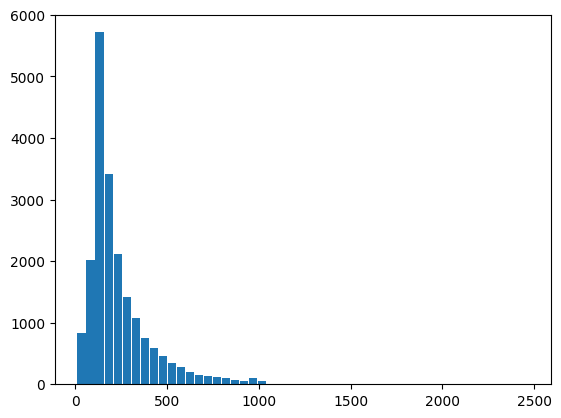

In [9]:
# Check sentence length distribution to understand if it makes sese to trim themt
lengths = []
for review in train_dset['text']:
    lengths.append(len(review.split(' ')))

import matplotlib.pyplot as plt
plt.hist(lengths, rwidth = 0.9, bins=50)

In [10]:
train_encodings = tokenizer(train_dset['text'], padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
val_encodings = tokenizer(val_dset['text'], padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
test_encodings = tokenizer(test_dset['text'], padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)

y_train = train_dset['label']
y_val = val_dset['label']
y_test = test_dset['label']

In [11]:
class IMDBDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].to(device) for key, val in self.encodings.items()}
        # import pdb; pdb.set_trace()
        item['labels'] = torch.tensor(self.labels[idx]).to(device)
        return item

    def __len__(self):
        return len(self.labels)

In [12]:
# def collate_fn(batch):
#     sentences = [item['text'] for item in batch]
#     tokenized = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

#     input_ids = tokenized['input_ids']
#     attention_mask = tokenized['attention_mask']
#     labels = torch.tensor([item['label'] for item in batch], dtype=torch.float16k).to(device)

#     return {
#         'input_ids': input_ids.to(device),
#         'attention_mask': attention_mask.to(device),
#         'labels': labels.to(device)
#     }

In [13]:
train_ds = IMDBDataset(train_encodings, y_train)
val_ds = IMDBDataset(val_encodings, y_val)
test_ds = IMDBDataset(test_encodings, y_test)

In [53]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [130]:
## from accelerate import accelerator
from transformers import AdamW
import torch.nn as nn

train_args = TrainingArguments(
    output_dir="./",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps = 500,
    weight_decay=0.01,
    logging_dir="./",
    logging_steps=10,
    dataloader_pin_memory=True
)

class DistilBERTForBinaryClassification(nn.Module):
    def __init__(self, num_classes, freeze_weights=True):
        super(DistilBERTForBinaryClassification, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(MODEL_NAME)

        if freeze_weights:
            for param in self.distilbert.parameters():
                param.requires_grad = False

        self.dropout1 = nn.Dropout(0.5)
        # TODO: properly check dimensions of the layer
        self.conv1d = nn.Conv1d(
            self.distilbert.config.hidden_size,
            self.distilbert.config.hidden_size // 2,
            kernel_size=7,
            padding='same'
        )

        self.maxp = nn.MaxPool1d(128)
        
        self.dropout2 = nn.Dropout(0.1)
        self.linear2 = nn.Linear(self.distilbert.config.hidden_size // 2, num_classes)

        # self.dropout2 = nn.Dropout(0.1)
        # self.linear2 = nn.Linear(self.distilbert.config.hidden_size // 2, num_classes)


    def forward(self, input_ids, attention_mask):
        # pooled_output = self.distilbert(input_ids, attention_mask)
        pooled_output = self.distilbert(input_ids, attention_mask)
        # cls_token_state = pooled_output[0][:, 0, :]
        pooled_output = pooled_output['last_hidden_state']
        output = self.dropout1(pooled_output)
        output = self.conv1d(output.permute(0,2,1))
        output = self.maxp(output)
        output = self.dropout2(output)
        # TODO: figure if it is needed to permute everything back again
        import pdb; pdb.set_trace()
        output = self.linear2(output)
        output = nn.Sigmoid()(output)  # Binary classification
        # output = self.linear1(output)
        # output = self.dropout2(output)
        # output = self.linear2(output)
        # output = nn.Sigmoid()(output)  # Binary classification
        return output

In [126]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def train(model, train_dataloader, optimizer, device, prog_bar):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # for batch_idx, batch in enumerate(train_dataloader):
    for batch_idx, batch in enumerate(prog_bar):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        labels = labels.reshape(-1, 1).float()

        outputs = model(input_ids, attention_mask)
        loss = nn.BCELoss()(outputs, labels)
        # loss = nn.CrossEntropyLoss()(outputs, labels)

        # Get predictions
        pred_labels = torch.round(outputs)

        total_correct += torch.sum(pred_labels == labels.reshape(-1, 1)).item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

        prog_bar.set_postfix({
            'batch_accuracy': (total_correct / total_samples),
            'batch_loss': loss.item()
        })

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    accuracy = total_correct / total_samples

    return average_loss, accuracy

def evaluate(model, eval_dataloader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in eval_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            labels = labels.reshape(-1, 1).float()

            outputs = model(input_ids, attention_mask)
            loss = nn.BCELoss()(outputs, labels)
            # loss = nn.CrossEntropyLoss()(outputs, labels)

            # Get predictions and compute accuracy and cumulative loss
            pred_labels = torch.round(outputs)
            total_correct += torch.sum(pred_labels == labels.reshape(-1, 1)).item()
            total_samples += labels.size(0)

            all_predictions.extend(pred_labels.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            total_loss += loss.item()

    average_loss = total_loss / len(eval_dataloader)
    accuracy = total_correct / total_samples
    accuracy = accuracy_score(all_labels, all_predictions)

    return average_loss, accuracy

def train_model(
    model,
    train_dataloader,
    eval_dataloader,
    optimizer,
    device,
    num_epochs,
    progressively_unfreeze=False
):
    model.to(device)

    for epoch in range(num_epochs):
        progress_bar = tqdm(train_dataloader, desc=f'epoch {epoch +1}', unit='batch')
        print(f"Epoch {epoch + 1}/{num_epochs}")

        train_loss, train_acc = train(model, train_dataloader, optimizer, device, progress_bar)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

        eval_loss, eval_acc = evaluate(model, eval_dataloader, device)
        print(f"Validation Loss: {eval_loss:.4f}, Validation Accuracy: {eval_acc:.4f}")

        # This is a naive attempt at progressively unfreezing distilbert parameters while training.x
        # This is clearly not working for some reason
        if progressively_unfreeze:
            for param in list(model.distilbert.parameters())[-epoch:]:
                 param.requires_grad = True

        print()


In [131]:
model = DistilBERTForBinaryClassification(num_classes=1)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import AdamW

model = DistilBERTForBinaryClassification(1)

optim = AdamW(model.parameters(), lr=2e-5)
train_model(model, train_dl, val_dl, optim, device, 8)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
epoch 1:   0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 1/8
> /tmp/ipykernel_32356/3495549829.py(55)forward()
     53         # TODO: figure if it is needed to permute everything back again
     54         import pdb; pdb.set_trace()
---> 55         output = self.linear2(output)
     56         output = nn.Sigmoid()(output)  # Binary classification
     57         # output = self.linear1(output)



ipdb>  output[:, 0, :].shape


torch.Size([32, 4])


In [ ]:
test_loss, test_accuracy = evaluate(model, test_dl, device)
print(f'test_loss: {test_loss}')
print(f'test_accuracy: {test_accuracy}')

In [ ]:
all_preds = []
all_labels = []
for idx, batch in enumerate(test_dl):
    if idx % 50 == 0:
        print(f'processing batch n. {idx}')
    preds = model(batch['input_ids'], batch['attention_mask'])
    preds = preds.cpu().round().flatten().int().tolist()  # Surely there's a better way
    all_preds.extend(preds)
    all_labels.extend(batch['labels'].cpu().tolist())

In [61]:
print(all_preds[:20])
print(all_labels[:20])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [67]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

print(classification_report(all_labels, all_preds))
print("\n")
print(f'f1_score: {f1_score(all_labels, all_preds)}')
print(f'accuracy_score: {accuracy_score(all_labels, all_preds)}')

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



f1_score: 0.8423118516441702
accuracy_score: 0.84252
